# Uso de métodos de regressão para a previsão do volume de chuva

## Leitura e filtragem inicial
Nesta etapa, os dados são lidos e todas as ocorrências de Tp_est = 0 são filtradas.

**Importante:** Alterar o valor da variável `DATA_FNAME` para o caminho onde o csv com o dataset está localizado.

In [1]:
import pandas as pd
DATA_FNAME = "./data/Dados_Radar_Estacao_Completo_2018_2022.csv"

# Lê dados e filtra linhas em que Tp_est != 0 e não há NaN's
data = pd.read_csv(DATA_FNAME)
data = data.loc[data["Tp_est"] != 0.0]


In [2]:
df = data.copy()

## Colunas auxiliares
Criação de colunas auxiliares. Para diminuir a dimensionalidade, os meses e as horas foram incorporados respectivamente em dias e minutos
- `year`: ano de coleta
- `day`: dia do ano contado a partir de 1 de janeiro
- `minute`: minuto do dia (hora * 60 + minuto)

In [3]:
from dateutil import parser

df.loc[:, 'year'] = df.apply(
    lambda row: parser.parse(row.time).year,
    axis = 1)

df.loc[:, 'day'] = df.apply(
    lambda row: parser.parse(row.time).timetuple().tm_yday,
    axis = 1)

df.loc[:, 'minute'] = df.apply(
    lambda row: parser.parse(row.time).hour*60 + parser.parse(row.time).minute,
    axis = 1)


## Definindo características
- O ano foi excluído das características porque a época do ano importa mais que o ano em si.
- Elevation e sweep foram excluídos, pois são iguais para todas as linhas.

In [4]:
x_cols = ['day', 'minute', 'UH', 'UV', 'DBZH', 'KDP', 'ZDR', 'RHOHV', 'lat', 'lon']
y_col = 'Tp_est'
cols = x_cols + [y_col]

## Tratando dados não existentes

**Dados de treino**
- Quando dados de treino possuírem valor "NaN", eles são preenchidos usando interpolação linear na função `getInterpolatedData`.
- A interpolação é feita separadamente para cada estação e os dados são ordenados por tempo.

**Dados de teste**
- Quando dados de teste possuírem valor "NaN", eles são preenchidos usando a média dos valores da coluna correspondente dos dados de treino na função `fillWithAverage`.
- A interpolação não usada neste caso para evitar data leakage.

In [5]:
def getInterpolatedData(data):
    stations = data['Est'].unique()
    newdf = pd.DataFrame()
    for station in stations:
        curdf = data.query('Est == "{}"'.format(station)).copy()
        curdf = curdf.sort_values(by=['year', 'day', 'minute'], ascending=[1, 1, 1])
        curdf = curdf.loc[:,cols]
        curdf = curdf.interpolate(method='linear', axis=0, limit_direction='forward')
        curdf = curdf.interpolate(method='linear', axis=0, limit_direction='backward')
        
        newdf = pd.concat([newdf, curdf], ignore_index=True)
    
    return newdf

def fillWithAverage(data_tst, data_trn):
    nancols = ['UH', 'UV', 'DBZH', 'KDP', 'ZDR', 'RHOHV']
    for col in nancols:
        mean = data_trn[col].mean()
        data_tst[col].fillna(mean, inplace=True)
    return data_tst

## Separação dos conjuntos de treino e teste

- O conjunto de treino usa interpolação para preencher os valores NaN.
- O conjunto de testes exclui as colunas com valor NaN.

In [6]:
trn = df.query('year!=2022').copy()
trn = getInterpolatedData(trn)

tst = df.query('year==2022').copy()
tst = fillWithAverage(tst, trn)
tst = tst.loc[:,cols]

x_tst = tst.loc[:, x_cols]
y_tst = tst.loc[:, y_col]
x_trn = trn.loc[:, x_cols]
y_trn = trn.loc[:, y_col]


## Aplicação da regressão
Neste trabalho, foram aplicados a árvore de decisão e o KNN para a regressão. Ambos apresentaram resultados bem parecidos.

### Árvore de decisão
Para evitar overfitting, a altura da árvore foi limitada e a quantidade mínima de elementos na folha também. Os valores para essas propriedades foram determinados experimentalmente.

In [7]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor(splitter="random", max_features="sqrt", min_samples_leaf=100, max_depth=10)
clf.fit(x_trn, y_trn)

DecisionTreeRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=100,
                      splitter='random')

#### Aplicando a árvore de decisão

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_pred = clf.predict(x_tst)

#### Plotando os resultados da árvore de decisão

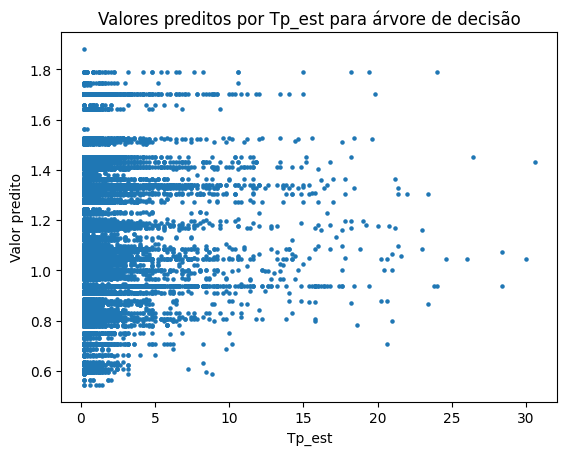

MSE:  3.9441853646553025
MAE:  1.0424111377036838


In [9]:
# importing the required module 
import matplotlib.pyplot as plt 

def plotResults(x_data, y_data, algorithm):
    plt.scatter(x_data, y_data, s=5)
    # plt.axis('scaled')
    
    plt.title('Valores preditos por Tp_est para {}'.format(algorithm)) 
    plt.xlabel('Tp_est')
    plt.ylabel('Valor predito') 
      
    # function to show the plot 
    plt.show() 

plotResults(y_tst, y_pred, "árvore de decisão")
print("MSE: ", mean_squared_error(y_tst, y_pred))
print("MAE: ", mean_absolute_error(y_tst, y_pred))


### KNN

In [10]:
from sklearn.neighbors import KNeighborsRegressor

clf = KNeighborsRegressor(200)
clf.fit(x_trn, y_trn)

KNeighborsRegressor(n_neighbors=200)

#### Aplicando o KNN

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_pred = clf.predict(x_tst)

#### Plotando os resultados do KNN e calculando os erros

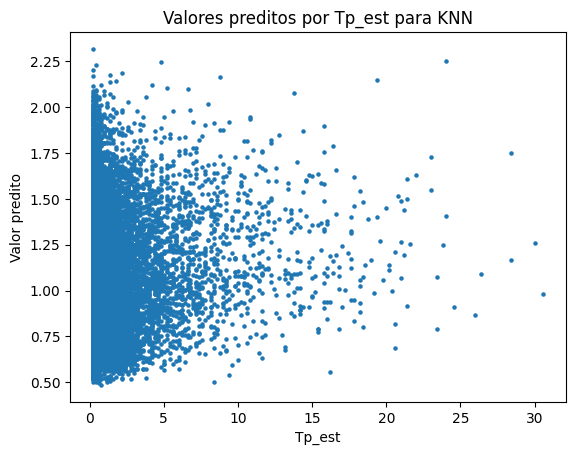

MSE:  3.9178095571452523
MAE:  1.0167561880810851


In [12]:
# importing the required module 
import matplotlib.pyplot as plt 

plotResults(y_tst, y_pred, "KNN")
print("MSE: ", mean_squared_error(y_tst, y_pred))
print("MAE: ", mean_absolute_error(y_tst, y_pred))